# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from PIL import Image
import site
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display
from IPython.display import Image as image2
from scipy import ndimage
from os.path import isfile, join
import h5py
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

In [2]:
from dataprep import *

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz
notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']
notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pi

In [3]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 188400437


In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save 

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size)).astype(np.float32)

  #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (40000, 28, 28) (40000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [5]:
####approach to create synthetic with own modifications but based on udacity forum discussion####
def createSequences(ndarr, labels_raw):
    length_number = 5
    stacked_pixelrow = image_size*length_number
    dataset_size = ndarr.shape[0]
    dataset_new = np.ndarray(shape=(dataset_size, image_size, stacked_pixelrow),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    #1/5 of total size since we always handle 5 images at once
    while i < (dataset_size/length_number):
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        ##if we keep this with i, we will have 32000 blue boxes
        dataset_new[i, :] = temp
        #adding a label id 5 for pos [0] to suggest length of number#
        temp_str = [labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4]]
        data_labels.append(temp_str)
        w += length_number
        i += 1
    #asarray instead of array, otherwise returns list 
    #still returns list
    np.asarray(data_labels)

    return dataset_new, data_labels

In [6]:
test_dataset, test_labels = createSequences(test_dataset, test_labels)
train_dataset, train_labels = createSequences(train_dataset, train_labels)
valid_dataset, valid_labels = createSequences(valid_dataset, valid_labels)

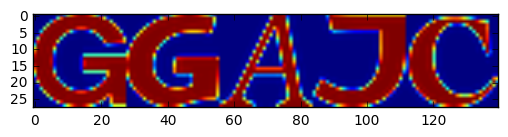

Label : [6, 6, 0, 9, 2]


In [9]:
import random

def displaySequence(n):
    fig=plt.figure()
    plt.imshow(train_dataset[n])
    plt.show()
    print ('Label : {}'.format(train_labels[n]))
    
displaySequence(7996)

In [10]:
#necessary to resize since we plugged 4/5th of our data into 1/5th
train_dataset = train_dataset[:8000]
valid_dataset = train_dataset[:2000]
test_dataset = train_dataset[:2000]

In [11]:
print('Training set', train_dataset.shape, len(train_labels))
print('Validation set', valid_dataset.shape, len(valid_labels))
print('Test set', test_dataset.shape, len(test_labels))

Training set (8000, 28, 140) 8000
Validation set (2000, 28, 140) 2000
Test set (2000, 28, 140) 2000


In [12]:
#changing image aspect ratio to lower learning burden on network

def resize_dataset(dataset):
    dataset_new = dataset[:,:,:28]
    for i in range(dataset.shape[0]):
        for pix_h in range(0,27):
            pix_w_new = 0
            for pix_w in range(0,134):               
                if pix_w % 5 == 0:
                    dataset_new[i][pix_h][pix_w_new] = (dataset[i][pix_h][pix_w] +dataset[i][pix_h][pix_w+1] +dataset[i][pix_h][pix_w+2]+\
            dataset[i][pix_h][pix_w+3]+dataset[i][pix_h][pix_w+4])/5
                    pix_w_new += 1
                    #print(pix_w_new)
    print(dataset_new.shape)
    return dataset_new

In [14]:
train_dataset = resize_dataset(train_dataset)
valid_dataset = resize_dataset(valid_dataset)
test_dataset = resize_dataset(test_dataset)

(8000, 28, 28)
(2000, 28, 28)
(2000, 28, 28)


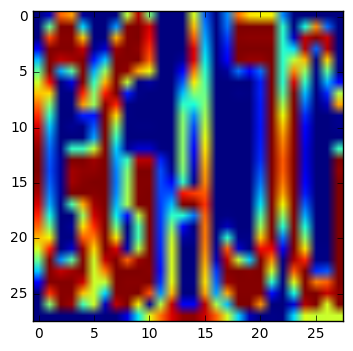

Label : [6, 6, 0, 9, 2]


In [15]:
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(train_dataset[n])
    plt.show()
    print ('Label : {}'.format(train_labels[n]))
    
displaySequence(7996)

In [16]:
#some additional reformatting will prepare this for the first simple NN
channels = 1


def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, channels)).astype(np.float32)
    #previous reformatting didnt capture this
    labels = np.asarray(labels)
    return dataset, labels

train_dataset, train_labels = reshape(train_dataset, train_labels)
test_dataset, test_labels = reshape(test_dataset, test_labels)
valid_dataset, valid_labels = reshape(valid_dataset, valid_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (8000, 28, 28, 1) (8000, 5)
Test set (2000, 28, 28, 1) (2000, 5)
Valid set (2000, 28, 28, 1) (2000, 5)


In [17]:
def accuracy_single(predictions, labels):
    #argmax selecting the value with the highest probability
    a = np.argmax(predictions, 2).T == labels[:,0:5]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    return(100 * summ / np.sum(length))

def accuracy_multi(predictions, labels):
    count = predictions.shape[1]
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,0:5] if False in i])) / count

In [20]:
#Filter size aka Patch
batch_size = 128
patch = 5
c1_out = 32
c2_out = 64
fc_out = 1024
num_labels = 10

graph = tf.Graph()
with graph.as_default():
  #loading training and verification data
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 5))
    
  tf_test_dataset = tf.constant(test_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  
  #definining helper functions
  def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_var(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  #defining weights and biases for each layer
  W_conv1 = weight_var([patch, patch, 1, c1_out])
  b_conv1 = bias_var([c1_out])

  W_conv2 = weight_var([patch, patch, c1_out, c2_out])
  b_conv2 = bias_var([c2_out])
    
  W_fc1 = weight_var([7 * 7 * c2_out, fc_out])
  b_fc1 = bias_var([fc_out])
    
  ###each logit gets its own weight and bias
  s1_w = weight_var([fc_out, num_labels])
  s1_b = bias_var([num_labels])   
  s2_w = weight_var([fc_out, num_labels])
  s2_b = bias_var([num_labels])  
  s3_w = weight_var([fc_out, num_labels])
  s3_b = bias_var([num_labels])   
  s4_w = weight_var([fc_out, num_labels])
  s4_b = bias_var([num_labels])   
  s5_w = weight_var([fc_out, num_labels])
  s5_b = bias_var([num_labels])
  
  #handler forward propagation through network
  def model(data):
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*c2_out])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #shape = h_fc1.get_shape().as_list()

    logits1 = tf.matmul(h_fc1, s1_w) + s1_b
    logits2 = tf.matmul(h_fc1, s2_w) + s2_b
    logits3 = tf.matmul(h_fc1, s3_w) + s3_b
    logits4 = tf.matmul(h_fc1, s4_w) + s4_b
    logits5 = tf.matmul(h_fc1, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
  ####comparing the predicted value of each logit with the actual label to calculate losses
  #single digit: loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.015).minimize(loss)
  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each position###
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)
  valid_prediction = prediction(tf_valid_dataset)

  saver = tf.train.Saver()

In [23]:
num_steps = 2001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 100 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    print('Validation accuracy for single digit: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
    print('Validation accuracy for full picture: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
    save_path = saver.save(session, "convnet5")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 63.874828
Minibatch accuracy for single digit: 8.3%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 100: 10.835314
Minibatch accuracy for single digit: 16.6%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 200: 8.008955
Minibatch accuracy for single digit: 36.9%
Minibatch accuracy for full picture: 3.1%
Minibatch loss at step 300: 6.103419
Minibatch accuracy for single digit: 48.2%
Minibatch accuracy for full picture: 5.5%
Minibatch loss at step 400: 4.950644
Minibatch accuracy for single digit: 55.0%
Minibatch accuracy for full picture: 18.8%
Minibatch loss at step 500: 5.774632
Minibatch accuracy for single digit: 51.4%
Minibatch accuracy for full picture: 9.4%
Minibatch loss at step 600: 4.129264
Minibatch accuracy for single digit: 60.3%
Minibatch accuracy for full picture: 21.1%
Minibatch loss at step 700: 3.887283
Minibatch accuracy for single digit: 60.7%
Minibatch accuracy for full picture: 25.0%
Minibatch 

In [253]:
#with tf.Session() as sess:
 # new_saver = tf.train.import_meta_graph('cnn.convnet.meta')
 # new_saver.restore(sess, tf.train.latest_checkpoint('./'))
 # test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_labels[:],})
 # print(test_prediction)

### Question 1
_What approach did you take in coming up with a solution to this problem?_

The underlying data set is notmnist numbers. The udacity exercise 1_notmnist approach was borrowed to load and format the data into a pickle.
Images have been concatenated in pairs of 5 and then resized to lower the computation burden for the Neural network.
While this distorted the aspect ratio, the synthetic dataset also reduced the training sample size to 8.000. 

I then applied a neural network with two convolutions, pooling and a fully connected layer. The detailed architecture is explained under the Q2 section. As the test accuracy was 7% on single digits and 0% on full images, localization of digits should be introduced next.
The result was obtained by reducing the learning rate from 0.5 to 0.015 and by setting the training steps to 2.000, since computational weight was deemed a constraint.

Initially, a sigmoid activation function has been set, but relus performed better by a 2-4% margin and thus remained in the model


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

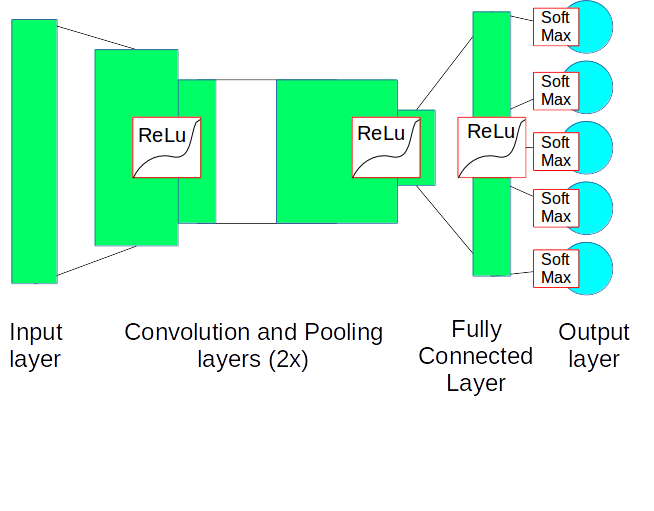

In [39]:
from IPython.display import Image
Image(filename =  "architecture.png", width=400)

The final architecture consists of five layers (seven respectively if convolution and pooling  are considered individual layers) and is displayed above:
-Input Layer : data reformatted to fit 4D tensor
-First Convolution Layer: includes a 5x5 patch and outputs a 32 feature channel, stride of 1 and padding "same" ensures input feature size equals output feature size. It is linked with a relu feeds into a 2x2 pooling layer, effectively reducing image size from 28x28 to 14x14 pixels.

-Second Convolution Layer, same setup as previous layer but additional pooling step reduces image size once more by half, resulting in 7x7px images.

-Fully connected Layer reshapes output from 2nd convolution to fit a 2D tensor with 1024 features. A relu introducing another nonlinearity is also included.

-Output layer with 5 logits for each digit is equipped with a softmax function to predict most likely digit.

The loss function includes each logit and feeds into an Adagrad learner that is set to a 0.015 learning rate yet due to the nature of adagrad also has some dynamic learning adaptation included.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

The model was trained by feeding the training set in batches of 128, out of the 8.000 picture repository. While we apply offset to create the batch, overlap between individual batches per training step is avoided.

Training the model involved identifying five digits per image, while the position of the digit within the image is unknown to the network, yet within predictable ranges due to proper cropping.

The synthetic dataset was created by concatenating five images as a numpy array and by applying similar concatenation with the labels.
After obtaining imaxes of the size 28x140 pixels, image aspect ratio has been adapted and image size changed to 28x28 pixels to reduce computational burden and simplify required feature learning.

Sample images can be seen above


----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [53]:
###for preprocessing of svhn file please see svhn_prep.ipynb or *.html file###
svhn_file=h5py.File("SVHN.hdf5","r")
#print(svhn_file.keys())

train_dataset = svhn_file['train_dataset'][()]
#print(train_dataset.shape[0])
train_labels = svhn_file['train_labels'][()]
test_dataset = svhn_file['test_dataset'][()]
test_labels = svhn_file['test_labels'][()]
svhn_file.close()

[ 2  2  9 10 10 10]


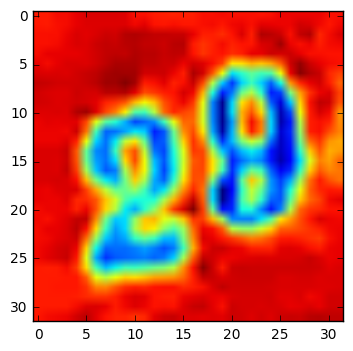

In [8]:
plt.imshow(train_dataset[100,:,:])
print(train_labels[100])

In [9]:
#measure taken due to resource exhaust errors and dead kernels

valid_dataset = test_dataset[1001:2001]
valid_labels = test_labels[1001:2001]
test_dataset = test_dataset[:1000] 
test_labels = test_labels[:1000]


In [10]:
image_size = 32
num_channels = 1
####for my non convoluted network attempt the formatting will go ahead with two keys for x and y parameters each

def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #setting this as float will cause problems
    labels = labels.astype(np.int32)
    return dataset, labels

train_dataset, train_labels = reshape(train_dataset, train_labels)
test_dataset, test_labels = reshape(test_dataset, test_labels)
valid_dataset, valid_labels = reshape(valid_dataset, valid_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (33402, 32, 32, 1) (33402, 6)
Test set (1000, 32, 32, 1) (1000, 6)
Valid set (1000, 32, 32, 1) (1000, 6)


In [11]:
def accuracy_single(predictions, labels):
    #argmax selecting the value with the highest probability
    #label index adapted since we wont predict the length of the number
    a = np.argmax(predictions, 2).T == labels[:,1:6]
    length = labels[:,0]
    summ = 0.0
    for i in range(len(length)):
        summ += np.sum(a[i,:length[i]])
    return(100 * summ / np.sum(length))

def accuracy_multi(predictions, labels):
    count = predictions.shape[1]
    #label index adapted since we wont predict the length of the number
    return 100.0 * (count - np.sum([1 for i in np.argmax(predictions, 2).T == labels[:,1:6] if False in i])) / count

In [24]:

batch_size = 128
patch = 5
c1_out = 32
c2_out = 64
fc_out = 1024
####changed from 10 to 11
num_labels = 11
channels = 1

graph = tf.Graph()
with graph.as_default():
  #loading training and verification data
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, channels))
    ####adapted 2nd dimension from 5 to 6 to account for additional label (length of number)###
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    
  tf_test_dataset = tf.constant(test_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  
  #definining helper functions
  def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_var(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  #defining weights and biases for each layer
  W_conv1 = weight_var([patch, patch, 1, c1_out])
  b_conv1 = bias_var([c1_out])

  W_conv2 = weight_var([patch, patch, c1_out, c2_out])
  b_conv2 = bias_var([c2_out])
  #####image size adapted to 8x8
  W_fc1 = weight_var([8 * 8 * c2_out, fc_out])
  b_fc1 = bias_var([fc_out])
    
  ###each logit gets its own weight and bias
  s1_w = weight_var([fc_out, num_labels])
  s1_b = bias_var([num_labels])   
  s2_w = weight_var([fc_out, num_labels])
  s2_b = bias_var([num_labels])  
  s3_w = weight_var([fc_out, num_labels])
  s3_b = bias_var([num_labels])   
  s4_w = weight_var([fc_out, num_labels])
  s4_b = bias_var([num_labels])   
  s5_w = weight_var([fc_out, num_labels])
  s5_b = bias_var([num_labels])
  
  #handler forward propagation through network
  def model(data):
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    #####image size adapted to 8x8
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*c2_out])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #shape = h_fc1.get_shape().as_list()

    logits1 = tf.matmul(h_fc1, s1_w) + s1_b
    logits2 = tf.matmul(h_fc1, s2_w) + s2_b
    logits3 = tf.matmul(h_fc1, s3_w) + s3_b
    logits4 = tf.matmul(h_fc1, s4_w) + s4_b
    logits5 = tf.matmul(h_fc1, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
   ####index of labels also adapted here###
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.015).minimize(loss)
  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each position###
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)
  valid_prediction = prediction(tf_valid_dataset)

  saver = tf.train.Saver()

In [26]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 1000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    print('Validation accuracy for single digit: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
    print('Validation accuracy for full picture: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
    save_path = saver.save(session, "convnet6")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 87.172516
Minibatch accuracy for single digit: 8.6%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 1000: 3.149318
Minibatch accuracy for single digit: 58.4%
Minibatch accuracy for full picture: 40.6%
Minibatch loss at step 2000: 2.457481
Minibatch accuracy for single digit: 67.8%
Minibatch accuracy for full picture: 55.5%
Minibatch loss at step 3000: 1.755094
Minibatch accuracy for single digit: 78.6%
Minibatch accuracy for full picture: 62.5%
Minibatch loss at step 4000: 1.387255
Minibatch accuracy for single digit: 83.0%
Minibatch accuracy for full picture: 70.3%
Minibatch loss at step 5000: 1.284262
Minibatch accuracy for single digit: 83.5%
Minibatch accuracy for full picture: 71.1%
Minibatch loss at step 6000: 0.929198
Minibatch accuracy for single digit: 87.8%
Minibatch accuracy for full picture: 78.1%
Minibatch loss at step 7000: 0.719007
Minibatch accuracy for single digit: 90.8%
Minibatch accuracy for full picture: 83.6%


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

Previous preformatting (executed in svhnprep file) enhanced contrast on the pictures by applying a heatmap-color scheme. Also, the data was normalized and shuffled to improve preconditions for training. Cropping was performed based on the bounding box information, so that all pictured fit within a 32x32 pixel format.

A critical decision was made when all digits within a number were kept as one picture, since this implied several predictions (number of predictions = length of number) per image and negative effects on the overall prediction quality since individual prediction accuracies are to be multiplied.

The training,testing and validation data for the actual training is split into the two respective buckets and consists of 33.000, 1.000 and 1.000 samples. Due to memory errors during training, the sample size for testing and validation had to be reduced. Minor additional reformatting took place before inserting the data into the Neural Network: The greyscale-color channel was selected for training.

Performance on the realistic dataset yielded the following results:
Test accuracy for single digit: 71.8%
Test accuracy for full picture: 57.3%
Validation accuracy for single digit: 72.2%
Validation accuracy for full picture: 57.5%

While this is far below human accuracy of 95-95%, it is deemed a robust result since digit locations inside the image are varying and thus affect prediction accuracies. Applying localization on the digits first should improve results here.


### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

Several iteration steps were taken so that the model was increased in complexity and accuracy step by step. Only the last step including several convolutions and pooling layers was kept in this workbook, while previous iteration steps can be seen in the github repo.

Since the initial not_mnist model has been adapted to predict for a 5-digit synthetic dataset, adaptations were minor

    different image sizes required resetting parameters after 2 pooling actions (7x7pixel setting changed to 8x8)
    an additional label was present that had to be predicted
    since the first label predicts the sequence length in the svhn dataset, the index position for the actual digit   predictions was changed in the accuracy function and the loss calculation

Some options that I explored making the quality of the prediction worse were:

    adding relus directly before the softmax (on the output layer)
    having less than 10.000 learning steps
    keeping learning rates in the loss function above 0.05 affected performance negatively
    testing different loss optimizer functions where adagrad proved most suitable
    
    backdrop was omitted in the convoluted approach due to computational weight yet it improved results marginally since it contributes to avoid overfitting


### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

Validation accuracy for single digit: 72.2%
Validation accuracy for full picture: 57.5%

As discussed in Q4, this is still significantly below human accuracy and the loss of accuracy might mostly be related to poor digit localization within the image. Since there is no opportunity to identify the position of a digit within an image, predictions are expected to worsen when image size is increased and additional noise (objects) would be included.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [36]:
own_file=h5py.File("ownnumbers.hdf5","r")
#print(svhn_file.keys())

own_dataset = own_file['own_dataset'][()]
own_labels = own_file['own_labels'][()]
own_file.close()

In [37]:
image_size = 32
num_channels = 1
####for my non convoluted network attempt the formatting will go ahead with two keys for x and y parameters each

def reshape(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #setting this as float will cause problems
    labels = labels.astype(np.int32)
    return dataset, labels

own_dataset, own_labels = reshape(own_dataset, own_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)
print('own set', own_dataset.shape, own_labels.shape)

Training set (33402, 32, 32, 1) (33402, 6)
Test set (1000, 32, 32, 1) (1000, 6)
Valid set (1000, 32, 32, 1) (1000, 6)
own set (5, 32, 32, 1) (5, 6)


In [85]:

batch_size = 128
patch = 5
c1_out = 32
c2_out = 64
fc_out = 1024
####changed from 10 to 11
num_labels = 11
channels = 1

graph = tf.Graph()
with graph.as_default():
  #loading training and verification data
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, channels))
    ####adapted 2nd dimension from 5 to 6 to account for additional label (length of number)###
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    
  tf_test_dataset = tf.constant(test_dataset)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_own_dataset = tf.constant(own_dataset)
  
  #definining helper functions
  def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_var(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  #defining weights and biases for each layer
  W_conv1 = weight_var([patch, patch, 1, c1_out])
  b_conv1 = bias_var([c1_out])

  W_conv2 = weight_var([patch, patch, c1_out, c2_out])
  b_conv2 = bias_var([c2_out])
  #####image size adapted to 8x8
  W_fc1 = weight_var([8 * 8 * c2_out, fc_out])
  b_fc1 = bias_var([fc_out])
    
  ###each logit gets its own weight and bias
  s1_w = weight_var([fc_out, num_labels])
  s1_b = bias_var([num_labels])   
  s2_w = weight_var([fc_out, num_labels])
  s2_b = bias_var([num_labels])  
  s3_w = weight_var([fc_out, num_labels])
  s3_b = bias_var([num_labels])   
  s4_w = weight_var([fc_out, num_labels])
  s4_b = bias_var([num_labels])   
  s5_w = weight_var([fc_out, num_labels])
  s5_b = bias_var([num_labels])
  
  #handler forward propagation through network
  def model(data):
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    #####image size adapted to 8x8
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*c2_out])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #shape = h_fc1.get_shape().as_list()

    logits1 = tf.matmul(h_fc1, s1_w) + s1_b
    logits2 = tf.matmul(h_fc1, s2_w) + s2_b
    logits3 = tf.matmul(h_fc1, s3_w) + s3_b
    logits4 = tf.matmul(h_fc1, s4_w) + s4_b
    logits5 = tf.matmul(h_fc1, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset)
     
   ####index of labels also adapted here###
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.015).minimize(loss)
  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each position###
  def prediction(dataset):
    prediction = tf.pack([
        tf.nn.softmax(model(dataset)[0]),
        tf.nn.softmax(model(dataset)[1]),
        tf.nn.softmax(model(dataset)[2]),
        tf.nn.softmax(model(dataset)[3]),
        tf.nn.softmax(model(dataset)[4])])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  test_prediction = prediction(tf_test_dataset)
  valid_prediction = prediction(tf_valid_dataset)
  own_prediction = prediction(tf_own_dataset)

  saver = tf.train.Saver()

NameError: name 'image_size' is not defined

In [44]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, batch_labels))
            print('Minibatch accuracy for full picture: %.1f%%' % accuracy_multi(predictions, batch_labels))
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
    print('Own pic Test accuracy for single digit: %.1f%%' % accuracy_single(own_prediction.eval(), own_labels))
    print('Own pic Test accuracy for full picture: %.1f%%' % accuracy_multi(own_prediction.eval(), own_labels))
    print('Validation accuracy for single digit: %.1f%%' % accuracy_single(valid_prediction.eval(), valid_labels))
    print('Validation accuracy for full picture: %.1f%%' % accuracy_multi(valid_prediction.eval(), valid_labels))
    save_path = saver.save(session, "convnet7")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 62.955055
Minibatch accuracy for single digit: 8.6%
Minibatch accuracy for full picture: 0.0%
Minibatch loss at step 500: 3.624362
Minibatch accuracy for single digit: 49.3%
Minibatch accuracy for full picture: 29.7%
Minibatch loss at step 1000: 2.996427
Minibatch accuracy for single digit: 59.0%
Minibatch accuracy for full picture: 39.8%
Minibatch loss at step 1500: 2.339356
Minibatch accuracy for single digit: 67.3%
Minibatch accuracy for full picture: 48.4%
Minibatch loss at step 2000: 2.319171
Minibatch accuracy for single digit: 70.5%
Minibatch accuracy for full picture: 57.0%
Minibatch loss at step 2500: 1.573509
Minibatch accuracy for single digit: 77.5%
Minibatch accuracy for full picture: 58.6%
Minibatch loss at step 3000: 1.666804
Minibatch accuracy for single digit: 80.4%
Minibatch accuracy for full picture: 68.8%
Test accuracy for single digit: 70.0%
Test accuracy for full picture: 53.8%
Own pic Test accuracy for single digit: 21.4%
Own

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_



Please see below for the images <strong>before</strong> preprocessing

While all images were cropped, resized and transformed to greyscale, there still is additional random objects and lines inside them. Also, some were particularly small and sometimes the pictures were taken from angles. One picture displayed a number carved in snow, which was particularly hard to read for the human eye.


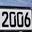

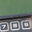

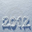

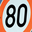

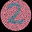

In [28]:
display(image2(filename="ownpic/2006.png"))
display(image2(filename="ownpic/789.png"))
display(image2(filename="ownpic/2012.png"))
display(image2(filename="ownpic/80.png"))
display(image2(filename="ownpic/2.png"))

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

Performance has dropped significantly.

We now obtained these results :
Own pic Test accuracy for single digit: 21.4%
Own pic Test accuracy for full picture: 20.0%
<br>
Previous results were:

Validation accuracy for single digit: 71.4%
Validation accuracy for full picture: 55.8%
<br>
This is most probably due to the circumstances stated in the Answer for Question 7

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
svhn_file=h5py.File("SVHN_all.hdf5","r")
#print(svhn_file.keys())

train_dataset = svhn_file['train_dataset'][()]
#print(train_dataset.shape[0])
train_labels = svhn_file['train_labels'][()]
test_dataset = svhn_file['test_dataset'][()]
test_labels = svhn_file['test_labels'][()]
#train_boxes = svhn_file['train_boxes'][()]
#test_boxes = svhn_file['test_boxes'][()]
#pic_dimensions = svhn_file['pic_dimensions'][()]
print("got all")
svhn_file.close()

got all


In [71]:
new_boxes = h5py.File('boxes_reshaped.hdf5',"r")
train_boxes = new_boxes['train_boxes_new'][()]
pic_dimensions = new_boxes['pic_dimensions'][()]
new_boxes.close()
print('done deal')

done deal


In [21]:
names = h5py.File('SVHN_names.hdf5',"r")
train_names = names['train_names'][()]
#new_boxes['test_boxes_new']
names.close()
print('done deal')

done deal


In [22]:
print(train_boxes.shape)
print(pic_dimensions.shape)
print(train_names.shape)

(33402, 4, 4)
(33402, 2)
(33402,)


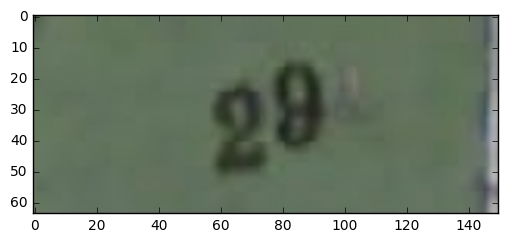

In [23]:
from PIL import Image, ImageDraw
filename = train_names[100]
fullname = os.path.join("train", filename)
im = Image.open(fullname)

plt.imshow(im)

In [45]:
print("box in resized digit1",train_boxes[100][0])#[0]  #last index 1-8 for each image
print("box in resized digit2", train_boxes[100][1])
print("image name", train_names[100])
print("image size", pic_dimensions[100])

box in resized digit1 [  5.          10.90909091   7.96363636  20.18181818]
box in resized digit2 [ 17.          10.36363636   4.14545455  20.18181818]
image name 9206.png
image size [150  64]


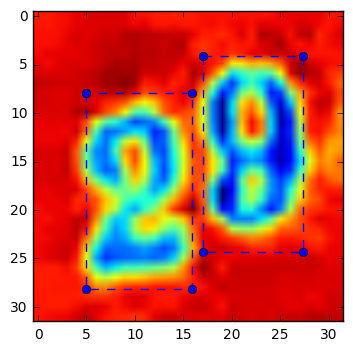

In [86]:
#check bounding boxes on a picture
from matplotlib.lines import Line2D 

boxes = train_boxes[100]
top = np.ndarray([len(boxes)], dtype='float32')
left = np.ndarray([len(boxes)], dtype='float32')
height = np.ndarray([len(boxes)], dtype='float32')
width = np.ndarray([len(boxes)], dtype='float32')
for i in range(0,len(boxes)):
    #x_coords = [boxes[i][0]]
    #y_coords = [boxes[i][0],boxes[i][3]]
    
    lx = boxes[i][0]
    width = boxes[i][1]
    top_y = boxes[i][2]
    height = boxes[i][3]
    
    y = [ top_y,top_y+height,top_y+height,top_y,top_y]
    x = [ lx, lx, lx+width, lx+width,lx]

    plt.plot(x, y, marker='o', linestyle='--', color='b')
   

plt.imshow(train_dataset[100,:,:])
plt.grid(False)




In [106]:
##for bette handling (like labels) even more reformatting here! 
lx_coords = []
width_coords = []
top_y_coords = []
height_coords = []

np.asarray(lx_coords)
np.asarray(width_coords)
np.asarray(top_y_coords)
np.asarray(height_coords)     
for i in range(0,len(train_boxes)):

    lx_coords.append(train_boxes[i][0])
    width_coords.append(train_boxes[i][1])
    top_y_coords.append(train_boxes[i][2])
    height_coords.append(train_boxes[i][3])
print("done")
        
print(len(width_coords))
print(len(train_boxes))

done
33402
33402


In [112]:
image_size = 32
num_channels = 1
####for my non convoluted network attempt the formatting will go ahead with two keys for x and y parameters each

def reshape(dataset, lx,width,topy,height):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #setting this as float will cause problems
    lx = np.asarray(lx)
    lx = lx.astype(np.int32)
    width = np.asarray(width)
    topy = np.asarray(topy)
    height = np.asarray(height)
    width = width.astype(np.int32)
    topy = topy.astype(np.int32)
    height = height.astype(np.int32)
    return dataset, lx, width, topy, height

train_dataset, lx_coords, width_coords, top_y_coords, height_coords = reshape(train_dataset,lx_coords, width_coords, top_y_coords, height_coords)
print('Training set', train_dataset.shape)# train_labels.shape)
print("lx_coords shape", lx_coords.shape)


Training set (33402, 32, 32, 1)
lx_coords shape (33402, 4)


In [114]:
batch_size = 128
patch = 5
c1_out = 32
c2_out = 64
fc_out = 1024
####changed from 10 to 11
num_labels = 11
channels = 1

graph = tf.Graph()
with graph.as_default():
  #loading training and verification data
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size, image_size, channels))
    ####adapted 2nd dimension from 5 to 6 to account for additional label (length of number)###
  

  ####batching needs to be re-implemented here
 # tf_train_lx  = tf.constant(lx_coords)
  #tf_train_width = tf.constant(width_coords)
 # tf_train_topy = tf.constant(top_y_coords)
  #tf_train_height = tf.constant(height_coords)
  tf_train_lx = tf.placeholder(tf.int32, shape=(batch_size,4))
  tf_train_width  = tf.placeholder(tf.int32, shape=(batch_size, 4))
  tf_train_topy  = tf.placeholder(tf.int32, shape=(batch_size, 4))
  tf_train_height  = tf.placeholder(tf.int32, shape=(batch_size, 4))

  #definining helper functions
  def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_var(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  #defining weights and biases for each layer
  W_conv1 = weight_var([patch, patch, 1, c1_out])
  b_conv1 = bias_var([c1_out])

  W_conv2 = weight_var([patch, patch, c1_out, c2_out])
  b_conv2 = bias_var([c2_out])
  #####image size adapted to 8x8
  W_fc1 = weight_var([8 * 8 * c2_out, fc_out])
  b_fc1 = bias_var([fc_out])
     
  ###I will start with predicting 1 bounding box for the first digit
  lx_w = weight_var([fc_out, num_labels])
  lx_b = bias_var([num_labels])   
  width_w = weight_var([fc_out, num_labels])
  width_b = bias_var([num_labels])  
  topy_w = weight_var([fc_out, num_labels])
  topy_b = bias_var([num_labels])   
  height_w = weight_var([fc_out, num_labels])
  height_b = bias_var([num_labels])   
  #####################################
  
  #handler forward propagation through network
  def model(data):
    h_conv1 = tf.nn.relu(conv2d(data, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    #####image size adapted to 8x8
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*c2_out])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


    logits1 = tf.matmul(h_fc1, lx_w) + lx_b
    logits2 = tf.matmul(h_fc1, width_w) + width_b
    logits3 = tf.matmul(h_fc1, topy_w) + topy_b
    logits4 = tf.matmul(h_fc1, height_w) + height_b

    return [logits1, logits2, logits3, logits4]

  # Training computation.
  #for a single digit: logits = tf.matmul(tf_train_dataset, weights) + biases
  [logits1, logits2, logits3, logits4] = model(tf_train_dataset)
     
   ####index of labels also adapted here###
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_lx[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_width[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_topy[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_height[:,0])) 
    
  
  #loss reduction with adagrad
  optimizer = tf.train.AdagradOptimizer(0.015).minimize(loss)
  #optimizer = tf.train.AdamOptimizer(0.5).minimize(loss)
  
  ####getting predictions from the logits###  
  #one prediction for each dimension###
 
  #####no softmax for regression#######
  def prediction(dataset):
    prediction = tf.pack([
        model(dataset)[0],
        model(dataset)[1],
        model(dataset)[2],
        model(dataset)[3]])
    return prediction
    
    
  train_prediction = prediction(tf_train_dataset)
  #test_prediction = prediction(tf_test_dataset)
  #valid_prediction = prediction(tf_valid_dataset)
  #own_prediction = prediction(tf_own_dataset)

  saver = tf.train.Saver()

In [115]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = tf_train_lx[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_lx : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy for single digit: %.1f%%' % accuracy_single(predictions, tf_train_lx))
            
            #print('prediction', predictions)
            #print('label', batch_labels[:,1:6])
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6])) 
    #print('Test accuracy for single digit: %.1f%%' % accuracy_single(test_prediction.eval(), test_labels))
    #print('Test accuracy for full picture: %.1f%%' % accuracy_multi(test_prediction.eval(), test_labels))
   
    save_path = saver.save(session, "convnet8")
    print("Model saved in file: %s" % save_path)

Initialized


TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, or numpy ndarrays.

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.